In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


import warnings
warnings.filterwarnings('ignore')
import time
import category_encoders
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoLars
from sklearn.kernel_ridge import KernelRidge

In [ ]:
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

# Imputing Missing Data

For the most part we will impute missing values with an "NA" label.

In [ ]:
train_data["PoolQC"] = train_data["PoolQC"].fillna("NA")

In [ ]:
test_data["PoolQC"] = test_data["PoolQC"].fillna("NA")

In [ ]:
all_bsmt_features = [feat for feat in train_data.columns if 'Bsmt' in feat]
bsmt_df = train_data[all_bsmt_features]
bsmt_df["BsmtQual"].fillna('TA', inplace = True)
bsmt_df["BsmtCond"].fillna('TA', inplace = True)
bsmt_df["BsmtFinType1"].fillna('Unf', inplace = True)
bsmt_df["BsmtFinType2"].fillna('Unf', inplace = True)
bsmt_df.loc[bsmt_df["BsmtExposure"].isna(), 'BsmtExposure'] = 'No'
train_data[all_bsmt_features] = bsmt_df.copy()

In [ ]:
bsmt_df2 = test_data[all_bsmt_features]
bsmt_df2["BsmtQual"].fillna('TA', inplace = True)
bsmt_df2["BsmtCond"].fillna('TA', inplace = True)
bsmt_df2["BsmtFinType1"].fillna('Unf', inplace = True)
bsmt_df2["BsmtFinType2"].fillna('Unf', inplace = True)
bsmt_df2.loc[bsmt_df2["BsmtExposure"].isna(), 'BsmtExposure'] = 'No'
test_data[all_bsmt_features] = bsmt_df2.copy()

In [ ]:
garage_features = [feat for feat in train_data if 'Garage' in feat]
missing_garage_features = set(garage_features) - set(["GarageArea","GarageCars",'GarageYrBlt'])
na_fill_dict = {col:'NoGarage' for col in missing_garage_features}
train_data.fillna(na_fill_dict, inplace = True)
test_data.fillna(na_fill_dict, inplace = True)
train_data['GarageYrBlt'].fillna(train_data['YearBuilt'], inplace = True)
test_data['GarageYrBlt'].fillna(test_data['YearBuilt'], inplace = True)

In [ ]:
mas_vnr_fillna = {'MasVnrArea': 0.0, 'MasVnrType': 'None'}
train_data.fillna(mas_vnr_fillna, inplace = True)
train_data['MiscFeature'].fillna("N/A", inplace = True)
train_data['FireplaceQu'].fillna('N/A', inplace = True)
train_data['Alley'].fillna('N/A', inplace = True)

test_data.fillna(mas_vnr_fillna, inplace = True)
test_data['MiscFeature'].fillna("N/A", inplace = True)
test_data['FireplaceQu'].fillna('N/A', inplace = True)
test_data['Alley'].fillna('N/A', inplace = True)

In [ ]:
train_data['LotDepth'] = train_data['LotArea']/train_data['LotFrontage']
test_data['LotDepth'] = test_data['LotArea']/test_data['LotFrontage']

In [ ]:
feats = ["GrLivArea","LotArea", "1stFlrSF"]
fig, ax = plt.subplots(3,2)
fig.set_figheight(10)
fig.set_figwidth(15)

ax[0,0].title.set_text("Non Missing Frontage Values")
ax[0,1].title.set_text("Missing Frontage Values")

i = 0
for feat in feats:
    ax[i,0].hist(train_data[train_data["LotFrontage"]!=np.nan][feat],bins = 20)
    ax[i,0].set_xlabel(feat)
    
    ax[i,1].hist(train_data[train_data["LotFrontage"].isna()][feat],bins = 20)
    ax[i,1].set_xlabel(feat)
    i = i+1
plt.tight_layout()

Here is a visualization of the LotFrontage feature and the filling of missing values with randomly selected values from the interquartile range, or the middle 50% of LotFrontage values.

In [ ]:
first_quartile_front = np.nanquantile(train_data["LotFrontage"], 0.25)
third_quartile_front = np.nanquantile(train_data["LotFrontage"], 0.75)
missing_vals_front = len(train_data[train_data["LotFrontage"].isna()]["LotFrontage"])
middle_50_front = np.linspace(first_quartile_front, third_quartile_front, missing_vals_front)

In [ ]:
first_quartile_depth = np.nanquantile(train_data["LotDepth"], 0.25)
third_quartile_depth = np.nanquantile(train_data["LotDepth"], 0.75)
missing_vals_depth = len(train_data[train_data["LotDepth"].isna()]["LotDepth"])
middle_50_depth = np.linspace(first_quartile_depth, third_quartile_depth, missing_vals_depth)

In [ ]:
train_data["LotFrontage"].fillna(np.random.choice(middle_50_front), inplace = True)
train_data["LotDepth"].fillna(np.random.choice(middle_50_depth), inplace = True)

test_data["LotFrontage"].fillna(np.random.choice(middle_50_front), inplace = True)
test_data["LotDepth"].fillna(np.random.choice(middle_50_depth), inplace = True)

In [ ]:
train_data["Fence"].fillna('N/A', inplace = True)
train_data["Electrical"].fillna("SBrkr", inplace = True)

test_data["Fence"].fillna('N/A', inplace = True)
test_data["Electrical"].fillna("SBrkr", inplace = True)

In [ ]:
train_data.drop(columns=["Id"], inplace = True)

# EDA and Feature Engineering

Now onto the fun stuff- Feature Engineering. This is where we will squeeze as much value out of our features as humanly possible!

In [ ]:
train_data["MoSold"].hist()

In [ ]:
median_price_month = train_data.groupby("MoSold").describe()["SalePrice"]["50%"]

In [ ]:
plt.bar(median_price_month.index, median_price_month)
plt.ylim(100000)

We will start by mapping the months of the year into distinct Season categories.

In [ ]:
seasons_map = {1:'Winter', 2:'Winter', 3:'Spring',4:'Spring',5:'Spring',6:'Summer',7:'Summer',8:'Summer',9:'Fall',10:
              'Fall', 11:'Fall',12:'Winter'}
train_data["Season"] = train_data["MoSold"].map(seasons_map)
test_data["Season"] = test_data["MoSold"].map(seasons_map)

In [ ]:
train_data["SalePrice"].hist()

train_data["GroupedPrice"] = pd.qcut(train_data["SalePrice"].copy(), q = 10)

In [ ]:
train_data["Season"].hist()
plt.title("Houses Sold by Season")

In [ ]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x="GroupedPrice", hue = "Season", data = train_data)

plt.xlabel('Price Range', size=15, labelpad=20)
plt.ylabel('Houses Sold', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(loc='upper right', prop={'size': 15})
plt.title('House Sold by {}'.format('Season'), size=15, y=1.05)

plt.show()

In [ ]:
sns.barplot(train_data["Season"], train_data["SalePrice"])

As many of us remember, the 2006-10 timeframe was heavily impacted by the mortgage crisis and the Great Recession. Thus, we will add a binary variable that will tell us if a house was sold during the recession (December 2007 to June 2009) or not. 

In [ ]:
recession_years = pd.Series((train_data["YrSold"] >= 2007) & (train_data["YrSold"] <= 2009)).astype(int)
recession_years_test = pd.Series((test_data["YrSold"] >= 2007) & (test_data["YrSold"] <= 2009)).astype(int)
recession_months = pd.Series(((train_data["MoSold"] == 12) & (train_data["YrSold"] == 2007)) | ((train_data["MoSold"] <= 6) & (train_data["YrSold"] == 2009)) | (train_data["YrSold"] == 2008))
recession_months = recession_months.astype(int)
recession_months_test = pd.Series(((test_data["MoSold"] == 12) & (test_data["YrSold"] == 2007)) | ((test_data["MoSold"] <= 6) & (test_data["YrSold"] == 2009)) | (test_data["YrSold"] == 2008))
recession_months_test = recession_months_test.astype(int)
is_recession = recession_years + recession_months
is_recession_test = list(recession_years_test + recession_months_test)

In [ ]:
is_recession = list(is_recession)
len_is_recession = len(is_recession)
for i in range(len_is_recession):
    if is_recession[i] != 0:
        is_recession[i] -= 1
is_recession_test = [is_recession_test[i]-1 for i in range(len(is_recession_test)) if is_recession_test[i] != 0]

In [ ]:
train_data["Is_Recession"] = pd.Series(is_recession)
test_data["Is_Recession"] = pd.Series(is_recession_test)

In [ ]:
train_data["SaleCondition"].replace(["Family","Alloca", "AdjLand"], ["Other"]*3, inplace = True)
train_data["SaleCondition"].value_counts()

In [ ]:
train_data["SaleType"].value_counts()

Here we are binning sparse classes (<50 instances of a given category) into an "Other" class. This will lead to less noise coming from categories with very few instances.

In [ ]:
saletype_sparse_class = set(train_data["SaleType"].value_counts().index) - set(['New', 'Oth', 'WD'])

In [ ]:
train_data["SaleType"].replace(list(saletype_sparse_class), ["Oth"]*len(saletype_sparse_class), inplace = True)
train_data["SaleType"].value_counts()

In [ ]:
train_data["MiscFeature"].value_counts()

In [ ]:
has_misc_array = np.zeros(1460)
misc_na_index = train_data[train_data["MiscFeature"] == "N/A"].index
misc_othr_index = train_data[train_data["MiscFeature"] != "N/A"].index
has_misc_array[misc_na_index] = 0
has_misc_array[misc_othr_index] = 1
train_data["HasMisc"] = has_misc_array

In [ ]:
fig, ax = plt.subplots(1,2)

ax[0].hist(train_data[train_data["Fence"] != "N/A"]["SalePrice"])
ax[1].hist(train_data[train_data["Fence"] == "N/A"]["SalePrice"])

plt.tight_layout()

In [ ]:
train_data[train_data["MiscVal"] == 0]["SalePrice"].describe()

In [ ]:
train_data[train_data["MiscVal"] != 0]["SalePrice"].describe()

In [ ]:
train_data[train_data["Fence"] != "N/A"]["SalePrice"].describe()

In [ ]:
train_data[train_data["Fence"] == "N/A"]["SalePrice"].describe()

In [ ]:
has_misc_array = np.zeros(1460)
misc_na_index = train_data[train_data["MiscFeature"] == "N/A"].index
misc_othr_index = train_data[train_data["MiscFeature"] != "N/A"].index
has_misc_array[misc_na_index] = 0
has_misc_array[misc_othr_index] = 1
train_data["HasMisc"] = has_misc_array

This "has_feature" function will be used extensively to generate new binary classes that show if a given feature is present in a house.

For example, if a house has Miscellaneous upgrades, the new Has_Misc feature will show a value of 1 for that house.

In [ ]:
def has_feature(old_feature, feature_split = "N/A", df = train_data):
    """Returns an array of binary classes that show if a given feature is 
    present in a house. This array can be used as a new column in your data.

        Parameters
        ----------
        old_feature : str
            The name of the column you want to generate a binary array for.
        feature_split : str/numerical
            The value present in the `old_feature` column that will result in a 0 value
            in the output binary array
            For example, if you wanted a column indicating if a house has a porch, 
            you would set the feature_split argument to 0 because 0 porch square footage means
            there is no porch
        df : pandas.DataFrame
            the input dataframe
        
        Returns
        ----------
        new_feature_arr : numpy.array
    """
    new_feature_arr = np.zeros(df.shape[0])
    na_index = df[df[old_feature] == feature_split].index
    othr_index = df[df[old_feature] != feature_split].index
    new_feature_arr[na_index] = 0
    new_feature_arr[othr_index] = 1
    return new_feature_arr

In [ ]:
test_data["HasMisc"] = has_feature("MiscFeature", feature_split = "N/A", df = test_data)

In [ ]:
train_data["HasFenceQ"] = has_feature("Fence")
test_data["HasFenceQ"] = has_feature("Fence", df = test_data)

In [ ]:
train_data["PoolQC"].unique()

In [ ]:
train_data[train_data["PoolQC"]!="NA"]["SalePrice"].describe()

In [ ]:
train_data[train_data["PoolQC"]=="NA"]["SalePrice"].describe()

In [ ]:
train_data["HasPool"] = has_feature("PoolQC", feature_split="NA")
test_data["HasPool"] = has_feature("PoolQC", feature_split="NA", df = test_data)

In [ ]:
plt.bar(train_data["OverallQual"], train_data["SalePrice"])

In [ ]:
plt.show(train_data[train_data["ScreenPorch"] > 0]["SalePrice"].hist())
print(train_data[train_data["ScreenPorch"] > 0]["SalePrice"].describe())

In [ ]:
plt.show(train_data[train_data["ScreenPorch"] == 0]["SalePrice"].hist())
print(train_data[train_data["ScreenPorch"] == 0]["SalePrice"].describe())

In [ ]:
train_data[(train_data["EnclosedPorch"] > 0) & (train_data["3SsnPorch"] > 0)]["SalePrice"] 

In [ ]:
train_data[(train_data["OpenPorchSF"] > 0) & (train_data["3SsnPorch"] > 0)]["SalePrice"] 

In [ ]:
train_data[(train_data["ScreenPorch"] > 0) & (train_data["3SsnPorch"] > 0)]["SalePrice"] 

In [ ]:
train_data[(train_data["ScreenPorch"] > 0) & (train_data["EnclosedPorch"] > 0)]["SalePrice"] 

In [ ]:
train_data[(train_data["ScreenPorch"] > 0) & (train_data["OpenPorchSF"] > 0)]["SalePrice"] 

In [ ]:
train_data[(train_data["EnclosedPorch"] > 0) & (train_data["OpenPorchSF"] > 0)]["SalePrice"]

In [ ]:
porch_list = ["EnclosedPorch", "OpenPorchSF", "ScreenPorch", "3SsnPorch"]
for porch in porch_list:
    train_data[f"Has{porch}"] = has_feature(porch, feature_split=0)
    test_data[f"Has{porch}"] = has_feature(porch, feature_split=0, df=test_data)

In [ ]:
has_porch_feats = ["HasEnclosedPorch", "HasOpenPorchSF", "HasScreenPorch", "Has3SsnPorch"]
train_data["PorchSum"] = pd.Series([0]*1460)
test_data["PorchSum"] = pd.Series([0]*1459)
for val in has_porch_feats:
    train_data["PorchSum"] += train_data[val]
    test_data["PorchSum"] += test_data[val]

In [ ]:
train_data[train_data["PorchSum"] == 2.0]["SalePrice"].describe()

In [ ]:
train_data[train_data["PorchSum"] != 2.0]["SalePrice"].describe()

In [ ]:
train_data.info()

In [ ]:
train_data.corr()["SalePrice"].sort_values(ascending=False)

In [ ]:
train_data["GroupedGrArea"] = pd.qcut(train_data["GrLivArea"], q = 6)

In [ ]:
gr_area_median = train_data.groupby("GroupedGrArea").describe()["SalePrice"]

In [ ]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.barplot(x= gr_area_median.index, y = gr_area_median["50%"])

plt.xlabel('Gr Area Range', size=15, labelpad=20)
plt.ylabel('Sale Price', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(loc='upper right', prop={'size': 15})
plt.title('Sale Price by {}'.format('Area'), size=15, y=1.05)

plt.show()

In [ ]:
train_data.info()

In [ ]:
train_data["HasWoodDeck"] = has_feature("WoodDeckSF", feature_split=0)
test_data["HasWoodDeck"] = has_feature("WoodDeckSF", feature_split = 0, df = test_data)

Here is a neat little helper function to quickly visualize the differences between the classes of a given feature.

For example, if you wanted to know how the differences in SaleCondition impacted SalePrice, you could use this feature_comparison function to quickly get a glimpse of that information!

In [ ]:
def feature_comparison(feature,df=train_data,feature_split="N/A", output = "SalePrice"):
    print(f"{feature} == {feature_split}\n\n", df[df[feature] == feature_split][output].describe())
    print(f"\n\n{feature} != {feature_split}\n\n",df[df[feature] != feature_split][output].describe())
    fig, ax = plt.subplots(1,2, sharex = True)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    for i in (0,1):
        ax[i].tick_params(axis='x', labelsize=14)
    ax[0].hist(df[df[feature] == feature_split][output])
    ax[0].set_title(f"Price Distribution when {feature} == {feature_split}")
    ax[1].hist(df[df[feature] != feature_split][output])
    ax[1].set_title(f"Price Distribution when {feature} != {feature_split}")
    plt.tight_layout()
    

In [ ]:
feature_comparison("WoodDeckSF", feature_split= 0)

In [ ]:
train_data.info()

In [ ]:
train_data["SaleCondition"].value_counts()
feature_comparison("SaleCondition", feature_split= "Normal")

In [ ]:
train_data["NormalCond"] = has_feature("SaleCondition", feature_split = "Normal")
test_data["NormalCond"] = has_feature("SaleCondition", feature_split = "Normal", df = test_data)

In [ ]:
train_data.corr()["SalePrice"].sort_values(ascending=False)

In [ ]:
train_data.info()

In [ ]:
feature_comparison("PavedDrive", feature_split = "N")

In [ ]:
train_data["PavedDrive"].replace("P", "Y", inplace = True)

In [ ]:
#just encode this feature
feature_comparison("PavedDrive", feature_split = "Y")

In [ ]:
train_data["Functional"].value_counts()

In [ ]:
feature_comparison("Functional",feature_split="Mod")

In [ ]:
train_data["Not_Typ"] = has_feature("Functional", feature_split = "Typ")
test_data["Not_Typ"] = has_feature("Functional", feature_split = "Typ", df = test_data)

In [ ]:
train_data["Not_Typ"].value_counts()

In [ ]:
train_data["TotalBaths"] = train_data["FullBath"] + (0.5*train_data["HalfBath"]) + train_data["BsmtFullBath"] + (0.5*train_data["BsmtHalfBath"])

In [ ]:
test_data["TotalBaths"] = test_data["FullBath"] + (0.5*test_data["HalfBath"]) + test_data["BsmtFullBath"] + (0.5*test_data["BsmtHalfBath"])

In [ ]:
train_data["TotalBaths"].value_counts()

In [ ]:
train_data["CombinedArea"] = train_data["GrLivArea"] + train_data["TotalBsmtSF"]

In [ ]:
test_data["CombinedArea"] = test_data["GrLivArea"] + test_data["TotalBsmtSF"]

In [ ]:
train_data["CombinedArea"].corr(train_data["SalePrice"])

In [ ]:
train_data["AgeAtSale"] = train_data["YrSold"] - train_data["YearBuilt"]
test_data["AgeAtSale"] = test_data["YrSold"] - test_data["YearBuilt"]

In [ ]:
train_data["AgeAtSale"].corr(train_data["SalePrice"])

In [ ]:
mult_floor_index = train_data[train_data["1stFlrSF"] != train_data["GrLivArea"]][["1stFlrSF","GrLivArea"]].index
mult_floor_index_test = test_data[test_data["1stFlrSF"] != test_data["GrLivArea"]][["1stFlrSF","GrLivArea"]].index
train_data["HasMultFloors"] = pd.Series([0]*1460)
train_data["HasMultFloors"][mult_floor_index] = 1

test_data["HasMultFloors"] = pd.Series([0]*1459)
test_data["HasMultFloors"][mult_floor_index_test] = 1

In [ ]:
feature_comparison("HasMultFloors", feature_split=0)

In [ ]:
train_data["BedsPlusBaths"] = train_data["BedroomAbvGr"] + train_data["TotalBaths"]

In [ ]:
test_data["BedsPlusBaths"] = test_data["BedroomAbvGr"] + test_data["TotalBaths"]

In [ ]:
train_data["AgeOfRemodel"] = train_data["YearRemodAdd"]- train_data["YrSold"] 
test_data["AgeOfRemodel"] = test_data["YearRemodAdd"]- test_data["YrSold"]  
train_data["AgeOfRemodel"].corr(train_data["SalePrice"])

In [ ]:
train_data["LotShape"].value_counts()

In [ ]:
feature_comparison("LotShape", feature_split="IR3")

In [ ]:
train_data["Is_Irregular"] = has_feature("LotShape", feature_split="Reg")
test_data["Is_Irregular"] = has_feature("LotShape", feature_split="Reg", df=test_data)
train_data["Is_Irregular"].corr(train_data["SalePrice"])

In [ ]:
train_data['BldgType'].value_counts()

In [ ]:
feature_comparison("BldgType", feature_split="1Fam")

In [ ]:
ordinal_features = set([col for col in train_data.columns if "Qu" in col]) - set(["LowQualFinSF"])

In [ ]:
ordinal_features = list(ordinal_features)

In [ ]:
feature_comparison("LowQualFinSF", feature_split=0)

In [ ]:
test_data["SaleType"].value_counts()

In [ ]:
train_data["IsOld"] = has_feature("SaleType", feature_split="New")
test_data["IsOld"] = has_feature("SaleType", feature_split = "New", df= test_data)

In [ ]:
train_data["IsOld"] = [1 if val == 0 else 0 for val in train_data["IsOld"]]
test_data["IsOld"] = [1 if val == 0 else 0 for val in test_data["IsOld"]]

In [ ]:
train_data["IsOld"].corr(train_data["SalePrice"])

In [ ]:
ordinal_features.append("SaleType")

In [ ]:
train_data["SaleType"].value_counts()
feature_comparison("SaleType",feature_split="New")

Now it's time for the juicy stuff: feature encoding.

Most machine learning models don't work too well with non-numerical data, so we need to "encode" those non-numerical features with numbers to feed into our models.

This ord_feat_encoding function strategically encodes the features based on the SalePrice of each class in that feature. For example, in the Neighborhoods feature, the neighborhoods with the highest median sale prices will correspond to the highest encoding value. 

This strategy increases the relationship of each of these non-numerical features with the SalePrice and leads to more accurate predictions!

In [ ]:
def ord_feat_encoding(input_feat, target_feat = "SalePrice", group_size = 1, visualize_only = False, df = train_data, map_df = False):
    feat_val_counts = df[input_feat].value_counts()
    feat_below_50 = [feat_val_counts.index[i] for (i, val) in enumerate(feat_val_counts) if val < 50]
    df[input_feat].replace(feat_below_50, ["Othr"] * len(feat_below_50), inplace = True)
    median_feat = df.groupby([input_feat]).describe()[target_feat]["50%"]
    median_feat = median_feat.sort_values()
    if visualize_only:
        plt.figure(figsize = (10,10))
        sns.barplot(median_feat, median_feat.index)
        plt.tick_params(axis='x', labelsize=10)
    median_feat_list = list(median_feat.index)
    
    def list_index(item):
        return (median_feat_list.index(item) // group_size) + 1
    if not visualize_only:
        feat_map = {val:list_index(val) for val in median_feat_list}
        if not map_df:
            df[f"{input_feat}Group"] = df[input_feat].map(feat_map)
        else:
            return feat_map

In [ ]:
ord_feat_encoding("Neighborhood", group_size = 3)

In [ ]:
train_data.select_dtypes("object").info()

In [ ]:
median_style = train_data.groupby(["HouseStyle"]).describe()["SalePrice"]["50%"]
median_style = median_style.sort_values()

In [ ]:
plt.figure(figsize = (10,10))
sns.barplot(median_style, median_style.index)
plt.tick_params(axis='x', labelsize=10)

In [ ]:
train_data["HouseStyle"].value_counts()

In [ ]:
ord_feat_encoding("HouseStyle", group_size=2)

In [ ]:
train_data["HouseStyleGroup"].corr(train_data["SalePrice"])

In [ ]:
train_data["Foundation"].replace(["Slab","Stone","Wood"], ["Other"]*3, inplace=True)

In [ ]:
ord_feat_encoding("Foundation", group_size = 1)

In [ ]:
ordinal_features

In [ ]:
ord_feat_encoding("SaleType", group_size = 1)

In [ ]:
train_data["GarageQual"].replace(["Fa", "Gd", "Po", "Ex"], ["Oth"] * 4, inplace = True)

In [ ]:
def corr_with(input_feat, target_feat = "SalePrice", df = train_data):
    return df[input_feat].corr(train_data[target_feat])

In [ ]:
ord_feat_encoding("KitchenQual", group_size = 1)

In [ ]:
corr_with("KitchenQualGroup")

In [ ]:
train_data.corr()["SalePrice"].sort_values(ascending=False)[0:10]

In [ ]:
ordinal_features

In [ ]:
train_data["ExterQual"].replace("Fa", "TA", inplace=True)

In [ ]:
ord_feat_encoding("ExterQual", group_size = 1)

In [ ]:
train_data["BsmtQual"].value_counts()

In [ ]:
ord_feat_encoding("BsmtQual", group_size=1)

In [ ]:
train_data["Condition1"].value_counts()

In [ ]:
train_data["Condition1"].replace(["RRAe", "RRAn", "RRNn", "RRNe"], ["RR"]*4, inplace=True)
train_data["Condition1"].replace(["PosN", "PosA"], ["Pos"]*2, inplace = True)

In [ ]:
ord_feat_encoding("Condition1", group_size=2)

In [ ]:
corr_with("Condition1Group")

In [ ]:
train_data["Condition2"].replace(list(set(train_data["Condition2"].value_counts().index)- set(["Norm"])),["Other"]*7, inplace=True)

In [ ]:
ext_val_counts = train_data["Exterior1st"].value_counts()
ext_below_50 = [ext_val_counts.index[i] for (i, val) in enumerate(ext_val_counts) if val < 50]
train_data["Exterior1st"].replace(ext_below_50, ["Othr"] * len(ext_below_50), inplace = True)

In [ ]:
ext_val_counts

In [ ]:
ord_feat_encoding("Exterior1st", visualize_only=True)

In [ ]:
roof_matl_replace = [val for val in train_data["RoofMatl"].value_counts().index if val != "CompShg"]
train_data["RoofMatl"].replace(roof_matl_replace, ["Othr"] * 7, inplace = True)

In [ ]:
train_data["RoofStyle"].replace(["Flat","Gambrel","Mansard", "Shed"], ["Othr"] * 4, inplace = True)

In [ ]:
ord_feat_encoding("RoofStyle")

In [ ]:
train_data["BldgType"].replace(["Twnhs", "2fmCon"], ["Duplex"]*2, inplace = True)

In [ ]:
ord_feat_encoding('BldgType')

In [ ]:
train_data["LandSlope"].replace("Sev", "Mod", inplace = True)

In [ ]:
train_data["LotShape"].replace("IR3", "IR2", inplace=True)

In [ ]:
train_data["LotConfig"].replace(["FR2", "FR3"], ["FR"] * 2, inplace = True)

In [ ]:
ord_feat_encoding("LotConfig")

In [ ]:
train_data["LandContour"].replace("Low","Lvl", inplace = True)

In [ ]:
ord_feat_encoding("LandContour")

In [ ]:
train_data["BsmtCond"].replace("Po", "Fa", inplace = True)

In [ ]:
ord_feat_encoding("BsmtCond")

In [ ]:
corr_with("BsmtCondGroup")

In [ ]:
train_data["MSZoning"].replace(["RH","C (all)"], ["Othr"] *2 , inplace = True)
train_data["MSZoning"].replace(["Othr"],["RM"], inplace = True)

In [ ]:
ord_feat_encoding("MSZoning", group_size = 1)

In [ ]:
train_data["HeatingQC"].replace("Po", "Fa", inplace = True)

In [ ]:
ord_feat_encoding("HeatingQC", group_size=1)

In [ ]:
already_encoded = [val.split('Group')[0] for val in train_data.columns if ("Group" in val) and ("Grouped" not in val)]

In [ ]:
object_columns = train_data.select_dtypes("object").columns

In [ ]:
for col in object_columns:
    if col not in already_encoded:
        ord_feat_encoding(col)

In [ ]:
corr_values = train_data.corr()["SalePrice"].sort_values(ascending=False)
best_features = corr_values[1:int(np.sqrt(1460))+1].index

In [ ]:
train_cols = list(set(best_features)-set(test_data.columns))

In [ ]:
group_cols = [val.split('Group')[0] for val in train_cols if "Group" in val]

In [ ]:
cols_to_group = test_data.select_dtypes('object').columns
for col in cols_to_group:
    feature_map = ord_feat_encoding(col, map_df=True)
    test_data[col+"Group"] = test_data[col].map(feature_map)

# Modeling

The long awaited moment has finally arrived- it's time to model!

We will start off by imputing any missing values in our test dataset and scaling the data using Sklearn's StandardScaler. This formula attempts to remove variability in the features by removing the mean and dividing by the standard deviation.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [ ]:
train_features = list(best_features)
train_features.append("SalePrice")

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
group_cols = [col for col in test_data.columns if 'Group' in col]
imp = SimpleImputer(missing_values=np.nan, strategy='median')
test_data[group_cols] = imp.fit_transform(test_data[group_cols])


In [ ]:
cat_columns = list(train_data.select_dtypes('object').columns)
test_data.drop(columns = cat_columns, inplace = True)
train_data.drop(columns = cat_columns, inplace = True)

In [ ]:
test_data["BsmtFullBath"].fillna(0.0, inplace=True)
test_data["BsmtHalfBath"].fillna(0.0, inplace = True)
test_data["BsmtFinSF2"].fillna(0.0, inplace = True)
test_data["BsmtUnfSF"].fillna(0.0, inplace = True)
test_data.drop(columns = "Is_Recession", inplace = True)
train_data.drop(columns = "Is_Recession", inplace = True)

In [ ]:
test_id = test_data["Id"]
test_data.drop(columns="Id", inplace=True)

In [ ]:
train_data.drop(columns=['GroupedGrArea', 'GroupedPrice'], inplace = True)

In [ ]:
X_train = StandardScaler().fit_transform(train_data.drop(columns = "SalePrice"))
y_train = train_data["SalePrice"]
X_test = StandardScaler().fit_transform(test_data)

Now is the time to select the most important features to feed into our model, and the Random Forest Regressor's **feat_importances** attribute is a great way of getting this done.

In [ ]:
regr = RandomForestRegressor(n_estimators=1000, max_depth = 4, n_jobs = -1)
regr.fit(X_train, y_train)
feat_list = list(train_data.columns)
feat_list.remove("SalePrice")
feat_importances = list(zip(feat_list, regr.feature_importances_))
feat_importances.sort(key = lambda val:val[1], reverse = True)
sorted_feats = [val[0] for val in feat_importances]

We will select the 90 most important features and once again use the StandardScaler to normalize the data.

In [ ]:
new_final_train, new_final_test = train_data[sorted_feats[0:90]], test_data[sorted_feats[0:90]]
na_list = ["BedsPlusBaths", "TotalBaths", "TotalBsmtSF", "GarageArea", "BsmtFinSF1", "GarageCars", "CombinedArea"]

for col in na_list:
    new_final_test[col].fillna(new_final_test[col].median(), inplace = True)

new_X_train = StandardScaler().fit_transform(new_final_train)
y_train = train_data["SalePrice"]
new_X_test = StandardScaler().fit_transform(new_final_test)

Our first model will be the **Extreme Gradient Boosting Regressor (XGB)**, a model that is commonly used in Kaggle competitions just like this one! XGB is an **ensembling** model in that it combines the predictions of multiple "weak" learners into a stronger prediction. 

It combines these predictions sequentially by continually testing the accuracy of the model on the train data (also known as cross-validation) and weighs the more accurate learners more heavily than the less accurate ones.

In [ ]:
xg_regr = xgb.XGBRegressor(silent=False,
                      booster = 'gbtree',
                      scale_pos_weight=1,
                      learning_rate=0.023,  
                      colsample_bytree = 0.4,
                      subsample = 0.7,
                      reg_lambda = 0.4,
                      n_estimators=900, 
                      reg_alpha = 52.1,
                      max_depth=4,
                      base_score = 0.5,
                      n_jobs = -1,
                      random_state = 42)

xg_regr.fit(new_X_train, y_train)
xg_preds = xg_regr.predict(new_X_test)

Ridge and Lasso Regression involve a technique known as **regularization** that minimize the likelihood of overfitting. Both algorithms consist of the same basic components as linear regression, but also include a regularization term that is designed to penalize inaccurate predictions and filter out the "noise" in your dataset.

In [ ]:
ridgeReg = Ridge(alpha=0.4, normalize = True, random_state=42)
ridgeReg.fit(new_X_train,y_train)
ridge_pred = ridgeReg.predict(new_X_test)

In [ ]:
lassoReg = Lasso(alpha=52.1, normalize=True, random_state=42)
lassoReg.fit(new_X_train,y_train)
lasso_pred = lassoReg.predict(new_X_test)

In [ ]:
avg_preds = (xg_preds + 0.1*(ridge_pred + lasso_pred))/1.2

We will also reintroduce our old friend the Random Forest Regressor! Similar to the XGB Regressor, the Random Forest is an ensembling technique that combines the predictions of many weak learners. 

However, while the XGB Regressor uses sequential **boosting**, the Random Forest model uses **bagging** or the average of the predictions of each of the individual decision trees in the model.

In [ ]:
rf = RandomForestRegressor(n_estimators=300,
                          max_depth=None,
                          min_samples_split=2,
                          min_samples_leaf=1,
                          max_features=None,
                          oob_score=True,
                          random_state=42,
                          n_jobs = -1)
rf.fit(new_X_train, y_train)
rf_preds = rf.predict(new_X_test)

Now onto the more specialized regression models:

**Least-angle regression (LARS)** is a method that calculates the feature most correlated with the target variable at each iteration of the algorithm. This combined with the Lasso regularization method produces a very accurate regression algorithm.

**Kernel Ridge regression** uses the "kernel-trick" to project the features into a higher dimension to better obtain an accurate linear regression line.

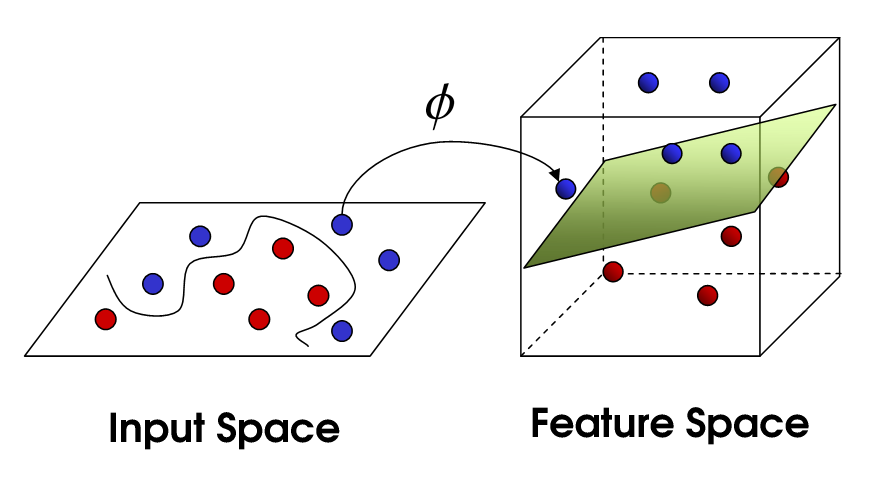

(Image source: https://datascience.stackexchange.com/questions/17536/kernel-trick-explanation)

In [ ]:
lasso_lars = LassoLars(alpha=46.65778907705154).fit(new_X_train, y_train)
lars_preds = lasso_lars.predict(new_X_test)

In [ ]:
kernel = KernelRidge(alpha=1.0, kernel='polynomial', degree=2, coef0=1.5)
kernel.fit(new_X_train, y_train)
kernel_preds = kernel.predict(new_X_test)

## Stacking and Blending Models

Here we will utilize the tremendous power of stacking and blending models to improve our predictions.

**Stacking** is an ensembling technique just like bagging and boosting, and it consists of combining the predictions of several models and running those predictions through yet another model, known as the **meta-regressor**. In our case, we will stack the Ridge Regression, Lasso Regression, XGB, Random Forest, Lasso Lars, and Kernel Ridge models and use the XGB as the meta-regressor. It's as thorough as it sounds!

In [ ]:
stack = StackingCVRegressor(regressors=(ridgeReg,lassoReg, rf, xg_regr, lasso_lars, kernel),
                                meta_regressor=xg_regr,
                                use_features_in_secondary=True)

In [ ]:
stack.fit(new_X_train, y_train)
stacked_preds = stack.predict(new_X_test)

In [ ]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)
def cv_rmse(model, X=train_data):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

**Blending** is a little simpler; it consists of multiplying our predictions by certain weights and adding them together. Here we will blend together the predictions of our Stacked model and our Kernel Ridge model in a roughly two-thirds to one-thirds ratio:

In [ ]:
kernel_blend = 0.66*stacked_preds + 0.34*kernel_preds

In [ ]:
output = pd.DataFrame({'Id': test_id, 'SalePrice': kernel_blend})
output.to_csv('my_submission2.csv', index=False)
print("Your submission was successfully saved!")

And that's all, folks! Through the power of feature engineering and stacking/blending a few well chosen models together, we were able to build a high-performing model. 